In [1]:
import sys
sys.path.append('F:\\pythonproject\\Tensor\\Chunk_v2\\')
import Chunk
print(Chunk.__file__)
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

D:\python\Lib\site-packages\Chunk\__init__.py


In [2]:
def select_z_score_lr(H_array,comm_matrix,threshold=2):
    from scipy.stats import zscore
    import pandas as pd
    df = pd.DataFrame(H_array,index = comm_matrix.index,columns=['loading'])
    df_filtered = df[df['loading'] != 0].copy()
    df_filtered['z_score'] = zscore(df_filtered['loading'])
    return df_filtered[df_filtered['z_score'] > threshold]


def merge_loading_dfs(df_dict):
    all_indexes = pd.Index([])  
    for df in df_dict.values():
        all_indexes = all_indexes.union(df.index)  

    final_df = pd.DataFrame(index=all_indexes)


    for df in df_dict.values():
        final_df['loading'] = final_df.get('loading', 0)  
        final_df['loading'] += df['loading'].reindex(final_df.index, fill_value=0)

    return final_df.sort_values(by='loading', ascending=False)

def result_NMF(W, H, comm_matrix, factor_list,position,zscore_threshold = 2):
    phe_factor_sampleW = {}
    phe_factor_cci = {}
    phe_factor_cciW = {}
    for i in factor_list:
        phe_factor_sampleW[i] = np.mean(W[:, i-1][position[0]-1:position[1]])
        phe_factor_cci[i] = select_z_score_lr(H[i-1],comm_matrix,threshold=zscore_threshold)
        phe_factor_cciW[i] = phe_factor_sampleW[i] * phe_factor_cci[i]
    final_df = merge_loading_dfs(phe_factor_cciW)
    #pd.DataFrame(H[1],index = interaction_scores.index,columns=['loading'])
    return final_df

In [3]:
fontsize = 16
plt.rcParams.update({
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize
})

In [4]:
bulk_samples = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\data\\simulate_1\\pheotype_bulkRNA_2.csv',index_col=0)
adata = sc.read_h5ad('F:\\pythonproject\\Tensor\\Chunk_v2\\data\\simulate_1\\pheotype_CCI_scRNA_2.h5ad')

D:\python\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
import pandas as pd

genes = bulk_samples.index.tolist()

interaction_pairs = [(genes[i], genes[i + 1]) for i in range(0, len(genes) - 1, 2)]

interaction_scores = pd.DataFrame(index=[f"{pair[0]}-{pair[1]}" for pair in interaction_pairs], columns=bulk_samples.columns)

for pair in interaction_pairs:
    gene1, gene2 = pair
    product = bulk_samples.loc[gene1] * bulk_samples.loc[gene2]
    interaction_scores.loc[f"{gene1}-{gene2}"] = np.sqrt(product)

comm_matrix2 = interaction_scores

In [7]:
diagonal_elements = np.concatenate((np.zeros(100), np.ones(100)))
S = np.diag(diagonal_elements)
phenotype_interval = {1: (0, 99), 2: (100, 199)}

In [8]:
optimal_K = Chunk.select_k_nmf(
    comm_matrix2.T.values.astype(float), S, k_max=20, repeat_times=5, verbose=True, 
    use_semi_supervised=True,
    semi_supervised_params={"alpha": 0.01, "beta": 0.01, "rho": 0.75}
)
print(f"Recommended K: {optimal_K}")

D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of ite

K=2, Reconstruction Error=25.1646
K=3, Reconstruction Error=21.2592
K=4, Reconstruction Error=18.5288
K=4, eii=0.4115
K=5, Reconstruction Error=17.1043
K=5, eii=0.1767
K=6, Reconstruction Error=14.7199
K=6, eii=0.2283
K=7, Reconstruction Error=14.3394
K=7, eii=0.0351
Recommended K: 6


D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of ite

In [9]:
W, H, loss_history = Chunk.LRcommMining(X = comm_matrix2.T.values.astype(float), S=S, n_components=optimal_K, alpha=0.005, beta=0.01, rho=0.75, maxiter=8000, lr=0.001)

D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


Iteration 0/8000, Loss: 13.5271
Iteration 50/8000, Loss: 13.4870
Iteration 100/8000, Loss: 13.4415
Iteration 150/8000, Loss: 13.3972
Iteration 200/8000, Loss: 13.3536
Iteration 250/8000, Loss: 13.3105
Iteration 300/8000, Loss: 13.2680
Iteration 350/8000, Loss: 13.2261
Iteration 400/8000, Loss: 13.1849
Iteration 450/8000, Loss: 13.1448
Iteration 500/8000, Loss: 13.1059
Iteration 550/8000, Loss: 13.0684
Iteration 600/8000, Loss: 13.0319
Iteration 650/8000, Loss: 12.9964
Iteration 700/8000, Loss: 12.9623
Iteration 750/8000, Loss: 12.9299
Iteration 800/8000, Loss: 12.8984
Iteration 850/8000, Loss: 12.8679
Iteration 900/8000, Loss: 12.8383
Iteration 950/8000, Loss: 12.8096
Iteration 1000/8000, Loss: 12.7816
Iteration 1050/8000, Loss: 12.7544
Iteration 1100/8000, Loss: 12.7278
Iteration 1150/8000, Loss: 12.7019
Iteration 1200/8000, Loss: 12.6767
Iteration 1250/8000, Loss: 12.6520
Iteration 1300/8000, Loss: 12.6279
Iteration 1350/8000, Loss: 12.6044
Iteration 1400/8000, Loss: 12.5815
Iteratio

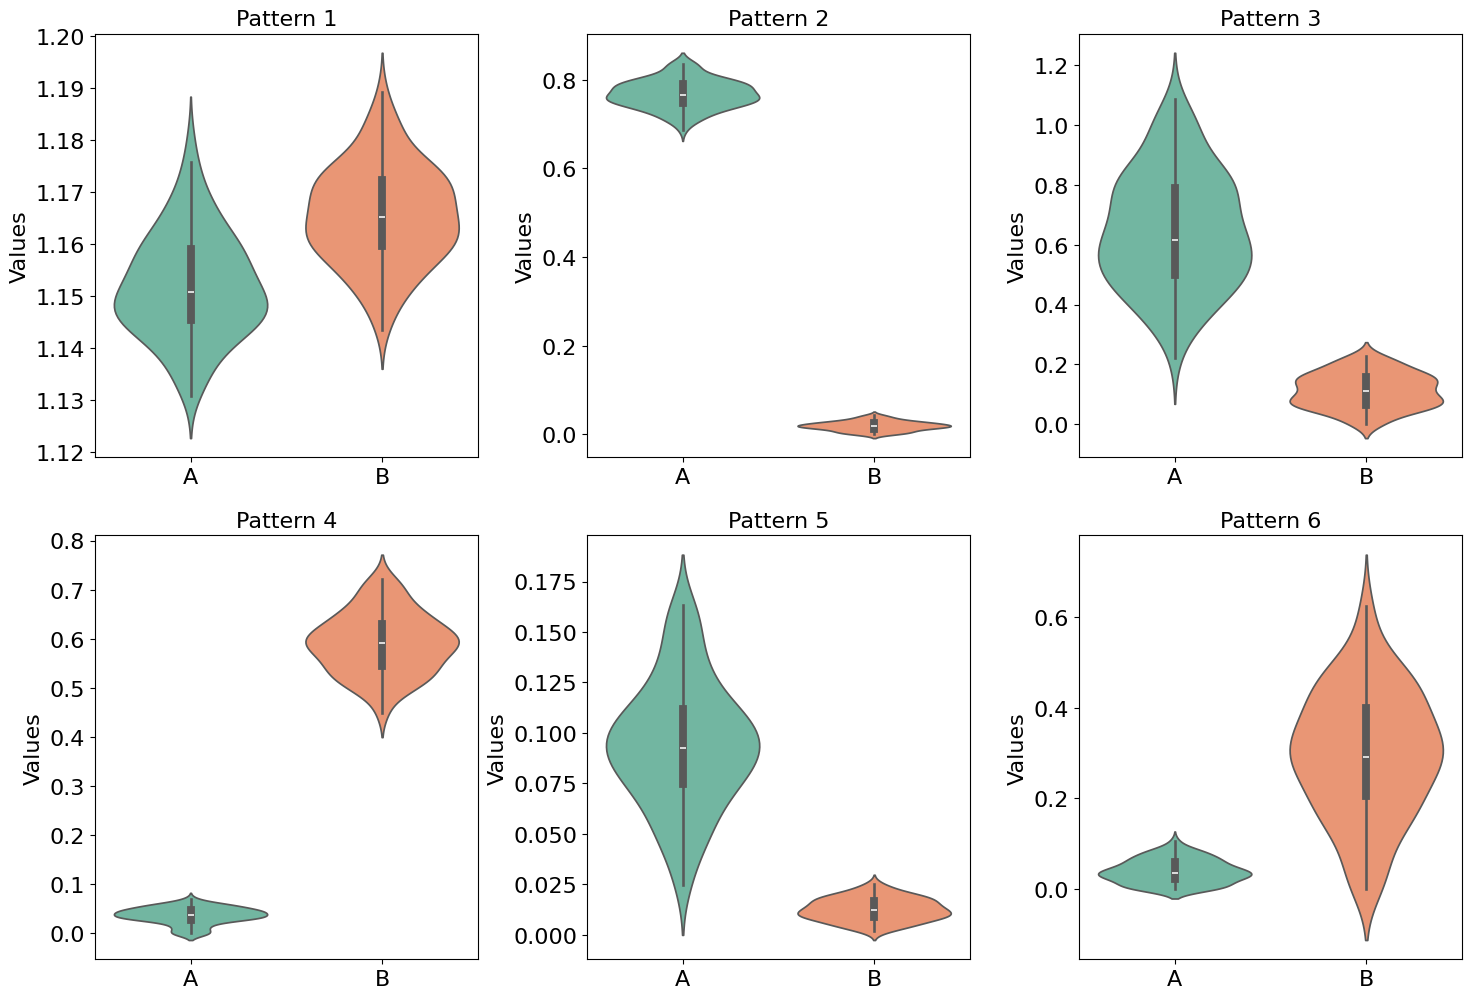

In [11]:
Chunk.getPatternDistribution(W, labels=['A', 'B'], phenotype_interval = phenotype_interval)#,savefig='E:\\NMF\\pic\\fig1\\simu1\\simulatedpattern.png'

In [12]:
res1 = result_NMF(W,H,comm_matrix2,factor_list = [2,3,5], position = [1,100],zscore_threshold = 0)

<Axes: >

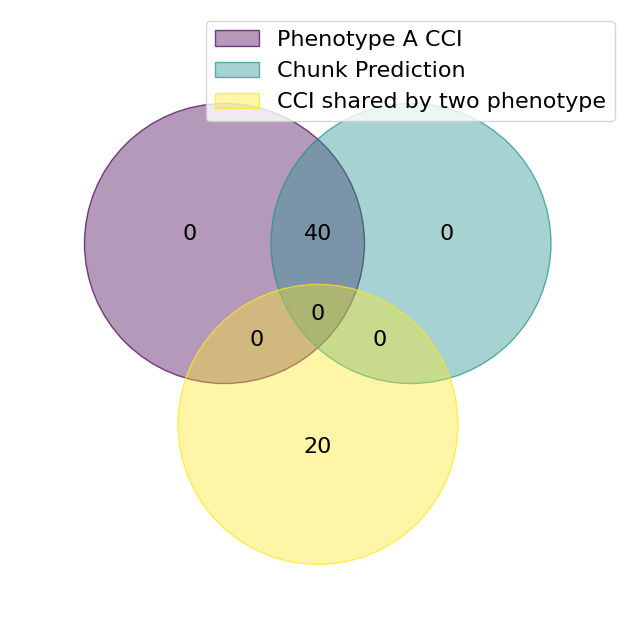

In [13]:
from venn import venn
Phe_A_cci = []
Phe_A_cci.extend([(genes[i]+'-'+genes[i + 1]) for i in range(0, 20 - 1, 2)])
Phe_A_cci.extend([(genes[i]+'-'+genes[i + 1]) for i in range(40, 60 - 1, 2)])
Phe_A_cci.extend([(genes[i]+'-'+genes[i + 1]) for i in range(80, 120 - 1, 2)])
Phe_common_cci = [(genes[i]+'-'+genes[i + 1]) for i in range(120, 160 - 1, 2)]
sets = {
    "Phenotype A CCI": set(Phe_A_cci),
    "Chunk Prediction": set(res1.index.tolist()),
    "CCI shared by two phenotype": set(Phe_common_cci)
}

venn(sets,fontsize=16)
#plt.savefig('E:\\NMF\\pic\\fig1\\simu1\\venn.png')

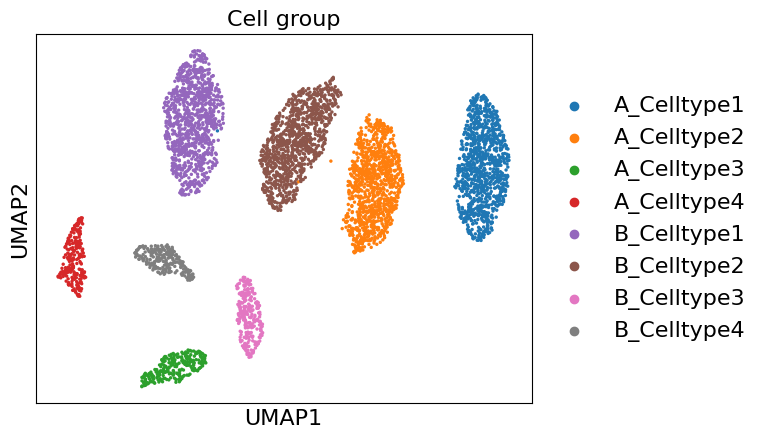

In [14]:
sc.pl.umap(adata, color='group',title ='Cell group')#,save='simulated1_umap.png'

In [15]:
sc_data = pd.DataFrame(adata.X,index=adata.obs_names,columns = adata.var_names).T.iloc[:160]
connectivities = Chunk.similarity2adjacent(adata,key='connectivities')
Y = np.concatenate([np.ones(100),np.zeros(100)]).astype(int).reshape(-1,1)
X = Chunk.calculate_correlation_matrix(bulk_samples, sc_data)

|**************************************************|
Performing quality-check for the correlations
The five-number summary of correlations:
Min: 0.12390596142706571
25th Percentile: 0.5473799703873481
Median: 0.6486900924786424
75th Percentile: 0.73383983847961
Max: 0.9087884599281247
|**************************************************|


D:\python\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [16]:
CCcomm = Chunk.CCcommInfer(method='binary',X = X, y = Y, alpha=0.1, lambda_=0.005, Omega=connectivities, learning_rate=0.0001, n_epochs=1000)

D:\python\Lib\site-packages\Chunk\CCcomm.py:360: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  self.L_sym = torch.sparse_csr_tensor(


Epoch [100/1000], Loss: 0.1128
Epoch [200/1000], Loss: 0.0632
Epoch [300/1000], Loss: 0.0507
Epoch [400/1000], Loss: 0.0461
Epoch [500/1000], Loss: 0.0439
Epoch [600/1000], Loss: 0.0427
Epoch [700/1000], Loss: 0.0419
Epoch [800/1000], Loss: 0.0413
Epoch [900/1000], Loss: 0.0408
Epoch [1000/1000], Loss: 0.0404


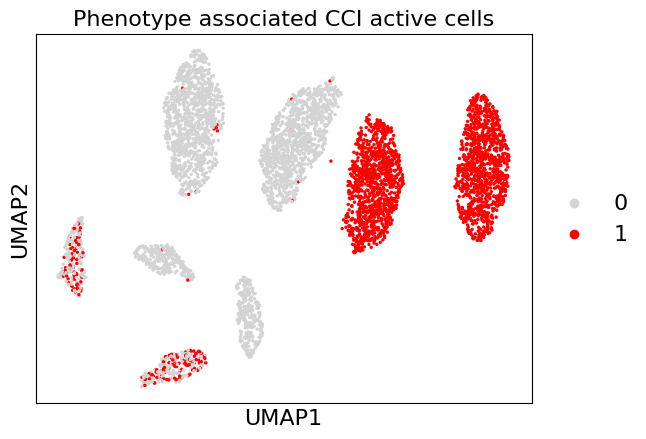

In [17]:
Chunk.getPosipotentialCCI(adata, CCcomm.model, threshold_percent=0)

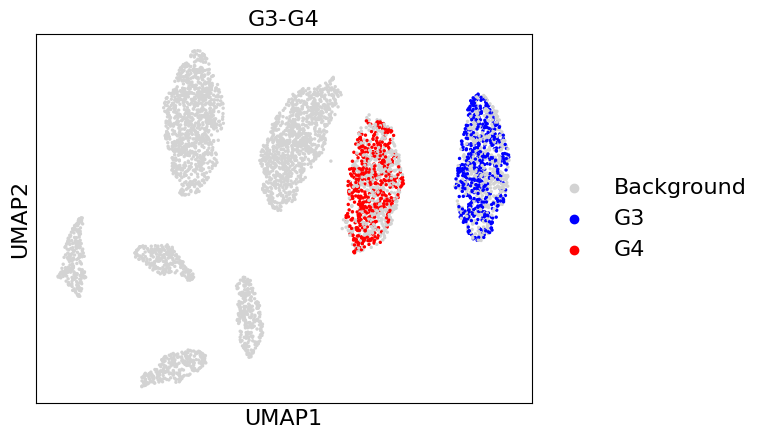

In [18]:
Chunk.getCCcomm(adata, 'G3', 'G4', L_threshold=10, R_threshold=10,  marked_col='phe_cell')

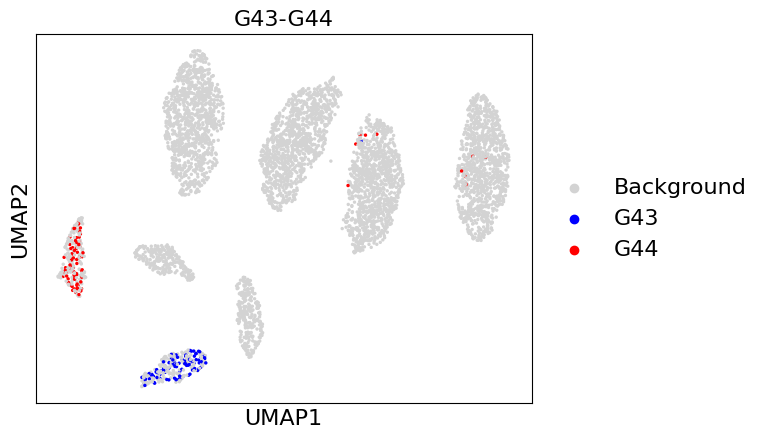

In [19]:
Chunk.getCCcomm(adata, 'G43', 'G44', L_threshold=5, R_threshold=5,  marked_col='phe_cell')

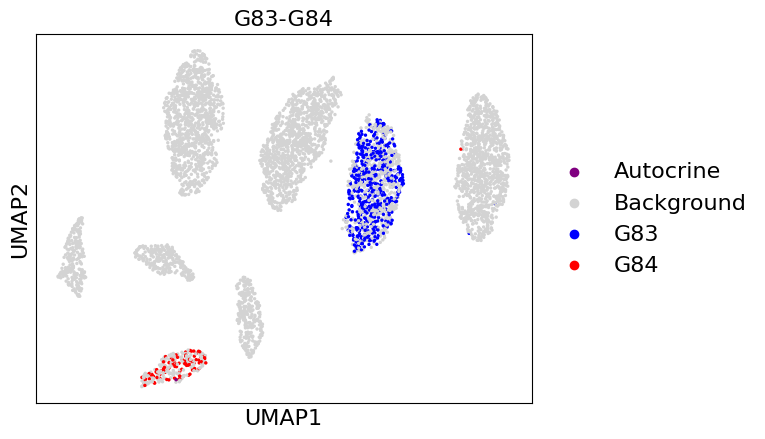

In [20]:
Chunk.getCCcomm(adata, 'G83', 'G84', L_threshold=10, R_threshold=5,  marked_col='phe_cell')

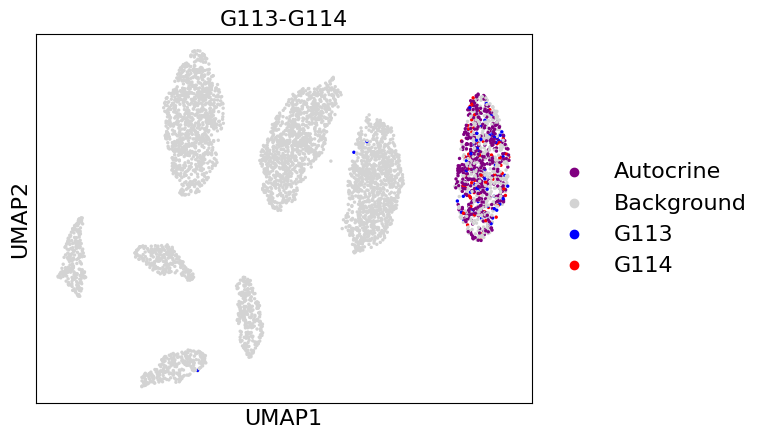

In [21]:
Chunk.getCCcomm(adata, 'G113', 'G114', L_threshold=10, R_threshold=10,  marked_col='phe_cell')